# IRCUR

Paper: https://arxiv.org/pdf/2010.07422.pdf

Matlab Script: https://github.com/caesarcai/IRCUR/blob/master/IRCUR.m

Full Repository: https://github.com/caesarcai/IRCUR

Related paper that is more recent: https://arxiv.org/pdf/2206.09042.pdf (on Riemannian CUR)

In [1]:
import numpy as np
from numpy import linalg as LA
import random
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import os
import torch
from torch import nn
from torch.optim import Adam
from torch.optim import SGD
import math

from helper import *

torch.set_printoptions(precision=3, sci_mode=True)

## Classical

In [2]:
np.random.seed(0)
torch.manual_seed(0)

## ======================== Parameters ========================
d1 = 2500                   # num. of rows
d2 = 2500                   # num. of columns
max_iter = 40              # num. of layers trained
r = 5
alpha = 0.3

## ======================== generate data ========================
L_true, S_true, M_true = generate_problem(r, d1, d2, alpha, c=1)

In [3]:
## start with M_true, assuming known rank
## error tolerance = 1e-6, gamma = 0.7, sampling constant = 3, max_iter = 100
loss, L_hat, S_hat = IRCUR(M_true, r, 1e-6, torch.tensor(0.7), 3, max_iter)

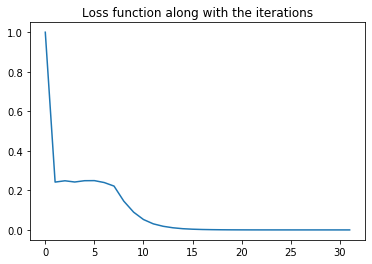

tensor(7.894e-07)
tensor(3.689e-07)
tensor(5.793e-06)


In [4]:
plt.plot(loss)
plt.title('Loss function along with the iterations')
plt.show()

print(loss[-1])
print(torch.linalg.norm(L_true - L_hat)/ torch.linalg.norm(L_true))
print(torch.linalg.norm(S_true - S_hat, 1)/ torch.linalg.norm(S_true, 1))

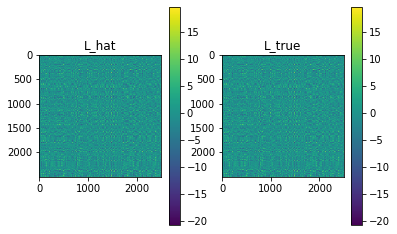

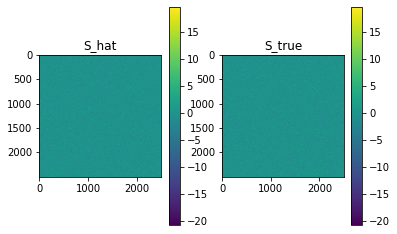

In [5]:
plot_true_vs_est_matrices(L_hat, L_true, S_hat, S_true)

## Unrolled version

In [6]:
## ======================== Learned IRCUR model ========================
## recover low-rank matrix L from M = L + S

# ======================== One Layer of the NN ========================
class InitStage(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, M0, r, con):
        m, n = M0.shape
        norm_of_M0 = torch.linalg.norm(M0)
        siz_row, siz_col = np.ceil(con * r * np.log(m)).astype(np.int64), np.ceil(con * r * np.log(n)).astype(np.int64)
        rows, cols = resample(m, n, siz_row, siz_col)
        C, pinv_U, R = torch.zeros([M0.shape[0], siz_col]), torch.zeros([siz_col, siz_row]), torch.zeros([siz_row, M0.shape[1]])
        zeta_init = torch.max(torch.abs(M0))
        return C, pinv_U, R, zeta_init, rows, cols

class ProjStage(nn.Module):
    def __init__(self, gamma, lay):
        super().__init__()
        self.gamma = gamma
        self.lay = lay

    def forward(self, M0, r, C, pinv_U, R, zeta_init, rows, cols):
        ## Update S
        zeta = zeta_init * torch.pow(self.gamma, self.lay)

        M0_rows = M0[rows, :]
        M0_cols = M0[:, cols]
        norm_of_M0 = torch.linalg.norm(M0_rows) + torch.linalg.norm(M0_cols)
        L_rows = C[rows, :] @ pinv_U @ R
        L_cols = C @ pinv_U @ R[:, cols]
        S_rows = thres(M0_rows - L_rows, zeta, hard=False)
        S_cols = thres(M0_cols - L_cols, zeta, hard=False)

        ## Update L
        C = M0_cols - S_cols
        R = M0_rows - S_rows
        MU = C[rows, :]
        U,Sigma,Vh = torch.linalg.svd(MU, full_matrices=False)
        ## calculate Moore-Penrose inverse of Sigma
        pinv_U = Vh.t()[:,:r] @ torch.diag(1./Sigma[:r]) @ U[:, :r].t()
        
        ## Compute err using previous L and current S
        err = (torch.linalg.norm(M0_rows - L_rows - S_rows) + torch.linalg.norm(M0_cols - L_cols - S_cols))/ norm_of_M0
        ## Resample rows and cols
        rows, cols = resample(M0.shape[0], M0.shape[1], len(rows), len(cols))
        return C, pinv_U, R, zeta, rows, cols, err

## ======================== Full NN with layers stacked ========================
class LearnedIRCUR(nn.Module):
    def __init__(self, max_iter):
        super().__init__()
        self.max_iter = max_iter
        self.gamma = nn.Parameter(torch.tensor(0.7))

        ## Stack layers
        self.layer = [InitStage()]
        for t in range(max_iter):
            # self.layer.append(ProjStage(gamma = nn.Parameter(torch.pow(self.gamma.clone().detach(), t + 1).requires_grad_(True))))
            self.layer.append(ProjStage(self.gamma, t+1))
        self.layers=nn.Sequential(*self.layer)
        ## Track loss
        self.loss = np.zeros(max_iter)
    
    def forward(self, M0, r, con):
        lay_init = self.layers[0]
        C, pinv_U, R, zeta_init, rows, cols = lay_init(M0, r, con)
        for t in range(1, self.max_iter + 1):
            lay = self.layers[t]
            C, pinv_U, R, zeta, rows, cols, err = lay(M0, r, C, pinv_U, R, zeta_init, rows, cols)
            self.loss[t-1] = err
        L = C @ pinv_U @ R
        S = thres(M0 - L, zeta)
        return L, S, err

## Old stuffs

### Learning from true data

In [13]:
np.random.seed(0)
torch.manual_seed(0)

## ======================== Parameters ========================
d1 = 250                   # num. of rows
d2 = 250                   # num. of columns
max_iter = 40              # num. of layers trained
r = 2
## ======================== generate data ========================
alpha_true = 0.3
c_true = 1
L_true, S_true, M_true = generate_problem(r, d1, d2, alpha_true, c_true)

In [14]:
net = LearnedIRCUR(max_iter)
L_bftrain, S_bftrain, err_bftrain = net(M_true, r, con=3) # assumes knowledge of rank
lossbftrain=np.array(net.loss)
params_bftrain = [x.clone().detach().numpy() for x in list(net.parameters())]

In [ ]:
optimizer=Adam(net.parameters(), lr=1e-5, weight_decay=1e-2)

nepochs = 50
for epoch in range(nepochs):  # loop over the dataset multiple times

    for i in range(50):
        L0, S0, M0 = generate_problem(r, d1, d2, alpha_true, c_true)
        optimizer.zero_grad()
        L_hat, S_hat, err = net(M0, r, con=3)
        loss = err \
            + (1/2) * torch.linalg.norm(L0 - L_hat)/torch.linalg.norm(L0) \
            + (1/2) * torch.linalg.norm(S0 - S_hat)/torch.linalg.norm(S0)
        loss.backward()
        # for name, param in net.named_parameters():
        #     if not torch.isfinite(param.grad).all():
        #         print(name, torch.isfinite(param.grad).all())
        #         break
        ## ISSUE: the gradient computed for some parameters become nan after calling backward()
        optimizer.step()
    print('Epoch ' + str(epoch+1) +'/' + str(nepochs) +' at cost=' + str(loss.item()))

print('Finished Training')

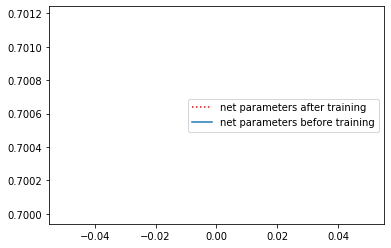

In [35]:
## plot learned parameters
plt.plot([x.detach().numpy() for x in list(net.parameters())],'r:',label='net parameters after training')
plt.plot(params_bftrain, label='net parameters before training')
plt.legend()
plt.show()

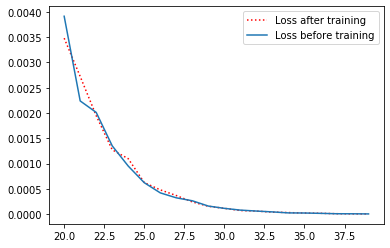

Before train
||L - L_hat||F: tensor(6.306e-04, grad_fn=<DivBackward0>)
||S - S_hat||1: tensor(1.740e-02, grad_fn=<DivBackward0>)
After train
||L - L_hat||F: tensor(5.106e-04, grad_fn=<DivBackward0>)
||S - S_hat||1: tensor(3.158e-02, grad_fn=<DivBackward0>)


In [36]:
L_hat, S_hat, err = net(M_true, r, con=3)
plt.plot(range(max_iter)[20:],np.array(net.loss)[20:],'r:',label='Loss after training')
plt.plot(range(max_iter)[20:],lossbftrain[20:],label='Loss before training')
plt.legend()
plt.show()
print("Before train")
print("||L - L_hat||F:", torch.linalg.norm(L_true - L_bftrain)/ torch.linalg.norm(L_true))
print("||S - S_hat||1:", torch.linalg.norm(S_true - S_bftrain, 1)/ torch.linalg.norm(S_true, 1))
print("After train")
print("||L - L_hat||F:", torch.linalg.norm(L_true - L_hat)/ torch.linalg.norm(L_true))
print("||S - S_hat||1:", torch.linalg.norm(S_true - S_hat, 1)/ torch.linalg.norm(S_true, 1))

In [37]:
print(torch.count_nonzero(S_true - S_bftrain))
print(torch.count_nonzero(S_true - S_hat))

tensor(55668)
tensor(44263)


In [38]:
print("Before train: ", lossbftrain[-1])
print("After train: ", np.array(net.loss)[-1])

Before train:  5.582648554991465e-06
After train:  5.588418844126863e-06


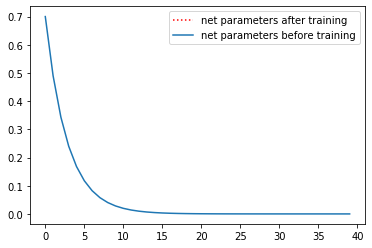

In [39]:
plt.plot([x.detach().numpy() for x in list(net.parameters())],'r:',label='net parameters after training')
plt.plot([0.7**i for i in range(1, 41)], label='net parameters before training')
plt.legend()
plt.show()

## when dimension of matrix is large (2500 x 2500)

In [56]:
np.random.seed(0)
torch.manual_seed(0)

## ======================== Parameters ========================
d1 = 2500                   # num. of rows
d2 = 2500                   # num. of columns
max_iter = 40              # num. of layers trained
r = 5
## generate data
alpha_true = 0.3
c_true = 1
L_true, S_true, M_true = generate_problem(r, d1, d2, alpha_true, c_true)
net = LearnedIRCUR(max_iter, gamma=torch.tensor(0.7))
L_bftrain, S_bftrain, err_bftrain = net(M_true, r, con=3) # assumes knowledge of rank
lossbftrain=np.array(net.loss.detach().numpy())
print(lossbftrain[-1])

3.6657202e-06


In [57]:
#optimizer=Adam(net.parameters(), weight_decay=0.9)
optimizer=Adam(net.parameters(), lr=1e-5)

nepochs = 100
for epoch in range(nepochs):  # loop over the dataset multiple times

    for i in range(50):
        L0, S0, M0 = generate_problem(r, d1, d2, alpha_true, c_true)
        optimizer.zero_grad()
        L_hat, S_hat, err = net(M0, r, con=3)
        loss = err + torch.linalg.norm(L0 - L_hat)/torch.linalg.norm(L0) + torch.linalg.norm(S0 - S_hat)/torch.linalg.norm(S0)
        #loss = err
        loss.backward()
        for name, param in net.named_parameters():
            if not torch.isfinite(param.grad).all():
                print(name, torch.isfinite(param.grad).all())
                break
        ## ISSUE: the gradient computed for some parameters become nan after calling backward()
        optimizer.step()
    print('Epoch ' + str(epoch+1) +'/' + str(nepochs) +' at cost=' + str(loss.item()))

print('Finished Training')

layers.6.gamma tensor(False)

Intel MKL ERROR: Parameter 4 was incorrect on entry to SLASCL.

Intel MKL ERROR: Parameter 4 was incorrect on entry to SLASCL.


_LinAlgError: linalg.svd: The algorithm failed to converge because the input matrix is ill-conditioned or has too many repeated singular values (error code: 24).

In [ ]:
L_hat, S_hat, err = net(M_true, r, con=3)
plt.plot(range(max_iter)[20:],net.loss.detach().numpy()[20:],'r:',label='Loss after training')
plt.plot(range(max_iter)[20:],lossbftrain[20:],label='Loss before training')
plt.show()
print("Before train")
print("||L - L_hat||F:", torch.linalg.norm(L_true - L_bftrain)/ torch.linalg.norm(L_true))
print("||S - S_hat||1:", torch.linalg.norm(S_true - S_bftrain, 1)/ torch.linalg.norm(S_true, 1))
print("After train")
print("||L - L_hat||F:", torch.linalg.norm(L_true - L_hat)/ torch.linalg.norm(L_true))
print("||S - S_hat||1:", torch.linalg.norm(S_true - S_hat, 1)/ torch.linalg.norm(S_true, 1))